<div class="alert alert-block alert-info">
Author:<br>Felix Gonzalez, P.E. <br> Adjunct Instructor, <br> Division of Professional Studies <br> Computer Science and Electrical Engineering <br> University of Maryland Baltimore County <br> fgonzale@umbc.edu
</div>

# Unsupervised Machine Learning - Clustering

In unsupervised machine learning (ML), an algorithm finds patterns in the data without using labeled data for training the model. The unsupervised ML is used to analyze and cluster unlabled dataset, discover similarities, find hidden patters, find outliers, etc. There are various data considerations and issues that may affect unsupervised machine learning, some include:
1. Knowing the shape of clusters will allow deciding which clustering algorithm would be best (e.g., centroid-based, density-based, etc.)
2. Is there overlap between clusters?
3. Do I need to identify outliers?

There are about a dozen clustering algorithms including but not limited to KMeans, DBSCAN, meanshift, OPTICS, etc. The SciKit Learn Library documentation has example on these and other algorithms (https://scikit-learn.org/stable/modules/clustering.html).

Other examples of unsupervised ML algorithms include dimensionality reduction. These are used to create convert a high dimensionality problem into a lower dimensionality problem by creating a lower dimension projection. Example algorihtms include [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), [T-distributed Stochastic Neighbor Embedding (TSNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), [singular value decomposition (SVD)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), among others. With high dimensional data (e.g., text), applying dimensionality reduction (e.g., PCA or TSNE) may help in finding patterns and/or improve the performance of other AI/ML models when used in conjunction.

One common examle of use of clustering algorithms is to target promotions targeted to those specific clusters/groups. You may need customer data on spending habits (e.g., total amount spent, customer age, household annual income, etc. Another example is to identify fraud, which could be accomplished by identifying outliers of clusters. This assumes that a customer behaves in a specific way while fraud deviates from the customer typical behavior.

In this notebook we will only be using two features. All features of a dataframe could be combined to do clustering on higher dimensional problem. Note that it is known that clustering algorithms may fail on higher dimensional problems and it is recommended to use dimensionality reduction in those cases.

Other Unsupervised ML References:
- https://machinelearningmastery.com/clustering-algorithms-with-python/
- https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python?select=Mall_Customers.csv

This notebook discusses example of using KMeans and DBSCAN.

# Loading Libraries

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np 
from numpy import unique, where
import matplotlib.pyplot as plt # Visualization Library

from sklearn.cluster import KMeans, DBSCAN # K-Means and DBSCAN algorithms
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score # Metrics 
from sklearn.neighbors import NearestNeighbors # Function to calculate distance to nearest neighbor points
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Scaling functions
from sklearn.datasets import make_blobs

import seaborn as sns # Visualization library

In [2]:
pd.set_option('display.max_colwidth', None) # PD has a limit of 50 characters.  Removes limit and uses the full text.
pd.options.display.float_format = "{:.2f}".format # Sets PD to displays float numbers as 4 decimal places.
plt.style.use('tableau-colorblind10') # Sets MatPlotLib default color style to 'tableau-colorblind10'

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Creating Synthetic Dataset
This example will use a syntetic dataset created using the make_blobs function and then converting to a dataframe.

In [4]:
# Makeblob used to generate 2d Synthetic dataset
# Good 2-cluster random_state: 2*, 3, 4* (non-discernible), 5 (non-discernible), 6, 12*, 
# Good 3-cluster random_state: 1, 2*
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, center_box = (10, 30), random_state = 2)
df_synthetic = DataFrame(dict(x=X[:,0], v=X[:,1])).round(2)
df_data = df_synthetic.copy()

X, y = make_blobs(n_samples=1000, centers=1, n_features=2, center_box = (10, 30), random_state = 4)
df_synthetic = DataFrame(dict(x=X[:,0], w=X[:,1])).round(2)
df_data = pd.concat([df_data, df_synthetic], ignore_index=True)

X, y = make_blobs(n_samples=1000, centers=2, n_features=2, center_box = (10, 30), random_state = 12)
df_synthetic = DataFrame(dict(x=X[:,0], y=X[:,1])).round(2)
df_data = pd.concat([df_data, df_synthetic], ignore_index=True)

X, y = make_blobs(n_samples=1000, centers=5, n_features=2, center_box = (10, 30), random_state = 2)
df_synthetic = DataFrame(dict(x=X[:,0], z=X[:,1])).round(2)
df_data = pd.concat([df_data, df_synthetic], ignore_index=True)

df_synthetic = pd.DataFrame(np.random.randint(0,30,size=(1000, 2)), columns=['x', 'r'])
df_data = pd.concat([df_data, df_synthetic], ignore_index=True)

# Scaling the data will typically improve the clustering.
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
df_scaled.sort_values(by=['x']).reset_index(drop=True)

,x,v,w,y,z,r
0,0.00,NaN,NaN,NaN,NaN,0.62
1,0.00,NaN,NaN,NaN,NaN,0.69
2,0.00,NaN,NaN,NaN,NaN,0.31
3,0.00,NaN,NaN,NaN,NaN,0.62
4,0.00,NaN,NaN,NaN,NaN,1.00
...,...,...,...,...,...,...
4995,1.00,NaN,0.42,NaN,NaN,NaN
4996,1.00,NaN,0.44,NaN,NaN,NaN
4997,1.00,NaN,0.40,NaN,NaN,NaN
4998,1.00,NaN,0.47,NaN,NaN,NaN


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       5000 non-null   float64
 1   v       1000 non-null   float64
 2   w       1000 non-null   float64
 3   y       1000 non-null   float64
 4   z       1000 non-null   float64
 5   r       1000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


# Visualizing Scatter Plot Data

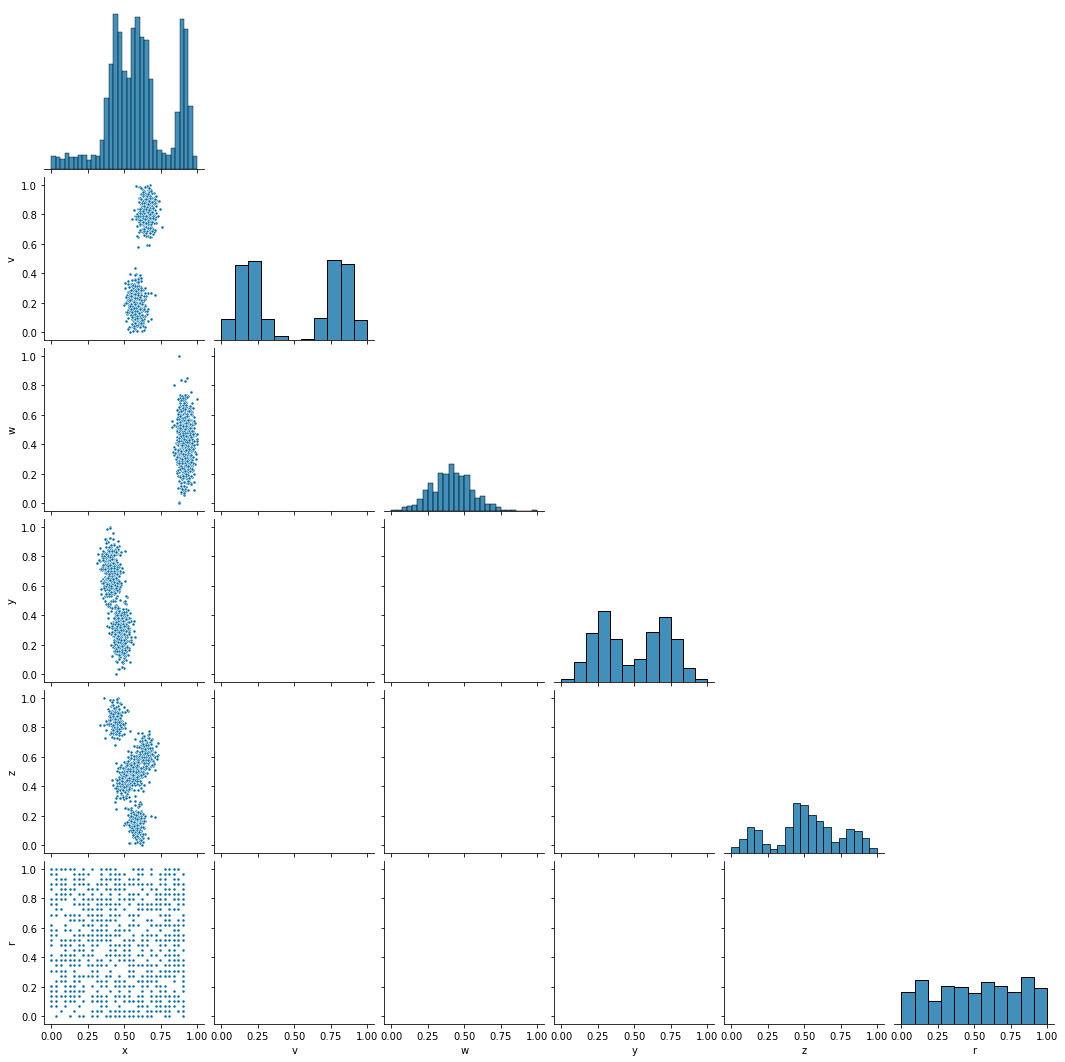

In [6]:
# SNS Pairplot Function
sns.pairplot(df_scaled, 
             corner = True, 
             kind = 'scatter',
             markers='.',
             height = 2.5);
# Features V, W, Y and Z are independent of each other. 
# Note that the other plots are blank when plotting one feature against another feature.
# In this dataset only the relationship of the features to X is important.
# There may be cases significant clusters may form with other feature combinations in your dataframe.
# Depending on your data, there may be cases where NO clusters form and those features may not be used for clustering. 
# Note that the pairplot figures are small and it may make sense to develop an individual scatter plots. See below.

#### Scatter Plot Function

In [7]:
def scatter_plot(col1, col2):
    # Scatter plot X vs. W
    plt.figure(figsize=(8, 8))
    plt.scatter(df_scaled[col1], 
                df_scaled[col2],
                marker='o', s=30, lw=0, alpha=1, c=None, cmap = 'Set1', edgecolor=None)
    plt.xlabel(col1, fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(col2, fontsize=18)
    plt.yticks(fontsize=14)
    plt.show()

# Clustering: KMeans
KMeans clustering algorithm is a centroid based algorithm that groups the data into a user predifined number of clusters (n or k). The algorithm, clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

In order to ensure that the algorithm selects significant clusters, the user can explore the most optimal number of clusters. There are various methods but the function below discuss the elbow method and the silhoutte score method. In the elbow method the most optimal number of clusters is in the point of highest curvature (i.e., the elbow). However, the elbow method is sometimes difficult especially when there are no discernible clusters, two or three. An alternative method is to use and the silhoutte score method. In the Silhoutte Score the user selects the number of clusters with the highest score.

One characteristic of Kmeans is that clusters are linearly separable.

References:
- https://scikit-learn.org/stable/modules/clustering.html#k-means
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- The [Kneed](https://kneed.readthedocs.io/en/stable/) library also can be used to calculate the point of maximum inflection in  elbow method.

### KMeans: Optimal Number of Clusters

In [9]:
def optimal_k_clusters(name_DF, col1, col2):
    # Drops rows where there are nulls and converts the data to an array.
    data_array = name_DF[[col1, col2]].dropna().reset_index(drop=True).to_numpy()    
    
    # Calculating the Cluster Score and Silhoutte Coefficient from 2 to 10 clusters.
    K = range(2, 11)
    km_scores= []
    km_silhouette = []

    # Iterates thru K number of clusters (2 thru 10) and calculates the Elbow and Silhoutte methods scores.
    for i in K:
        km = KMeans(n_clusters=i, random_state=42).fit(data_array)
        km_scores.append(-km.score(data_array)) # Elbow method score.
        
        preds = km.predict(data_array)
        silhouette = silhouette_score(data_array, preds)
        km_silhouette.append(silhouette) # Silhoutte method scores
        
    # Plot of the elbow method scores. Used to calculate optimal number of kmeans clusters.
    plt.figure(figsize=(8,4))
    plt.title("The elbow method for determining number of clusters\n",fontsize=16)
    plt.scatter(x = [i for i in K],y = km_scores, s = 150, edgecolor = 'k')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel("K-means score",fontsize=15)
    plt.xticks([i for i in K],fontsize=10)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Plot of the silhoutte method scores. Used to calculate optimal number of kmeans clusters.
    plt.figure(figsize=(8,4))
    plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
    plt.scatter(x = [i for i in K], y = km_silhouette, s = 150, edgecolor = 'k')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel("Silhouette score",fontsize=15)
    plt.xticks([i for i in K],fontsize=10)
    plt.yticks(fontsize=12)
    plt.show()

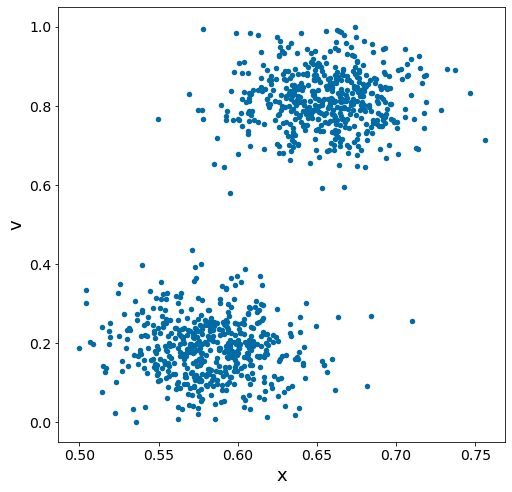

In [10]:
scatter_plot(col1 = 'x', col2 = 'v')
# There is definitely two defined clusters and maybe a few outliers.

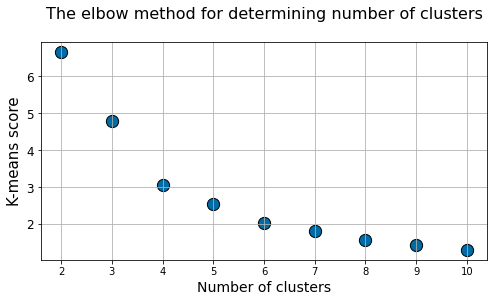

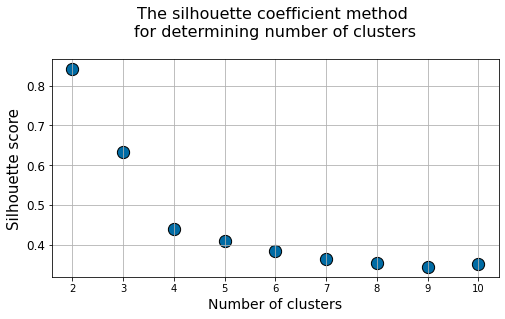

In [11]:
optimal_k_clusters(name_DF = df_scaled, col1 = 'x', col2 = 'v')

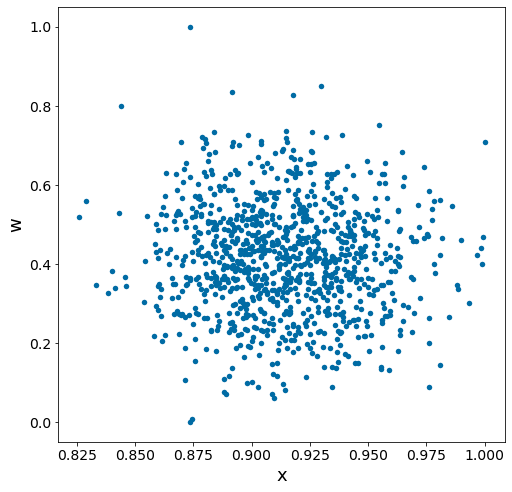

In [12]:
scatter_plot(col1 = 'x', col2 = 'w')
# Data points seem to be one big cluster with potential outliers.

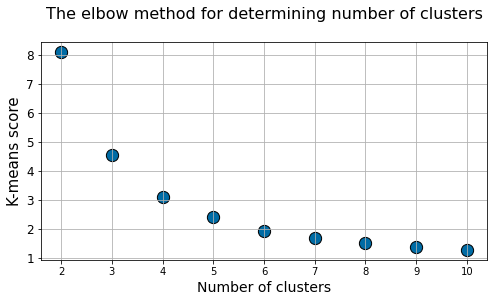

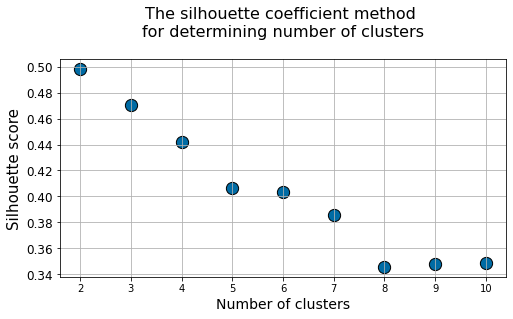

In [13]:
optimal_k_clusters(name_DF = df_scaled, col1 = 'x', col2 = 'w')

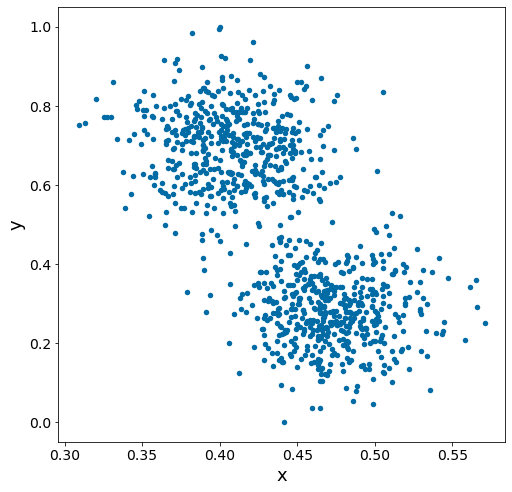

In [14]:
scatter_plot(col1 = 'x', col2 = 'y')
# Two defined clusters with few outliers.

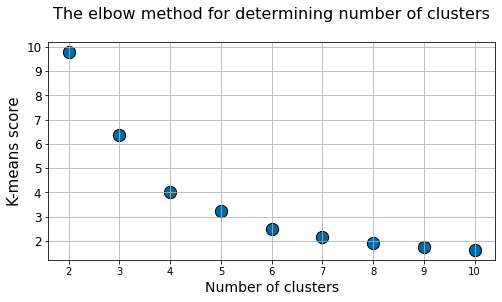

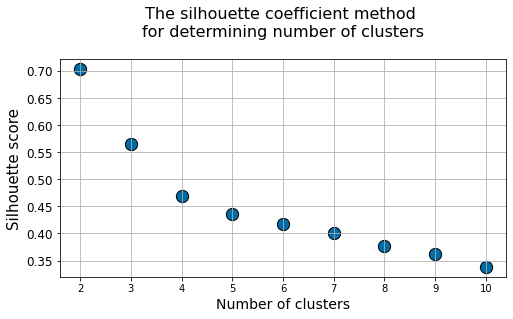

In [15]:
optimal_k_clusters(name_DF = df_scaled, col1 = 'x', col2 = 'y')

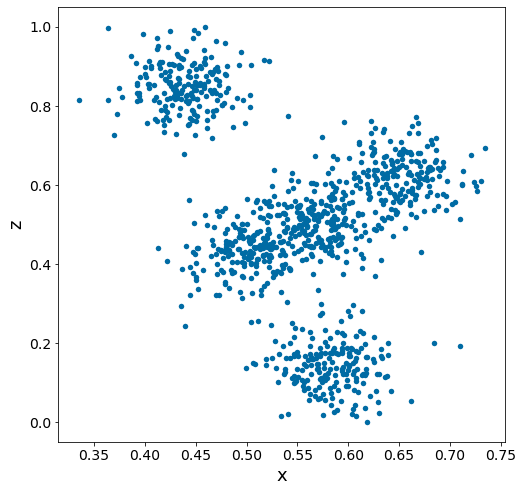

In [16]:
scatter_plot(col1 = 'x', col2 = 'z')
# Two defined clusters. The top clusters could potnetially be divided in two.

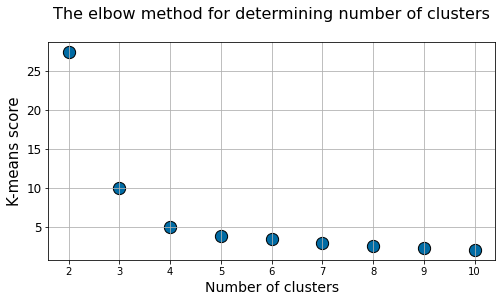

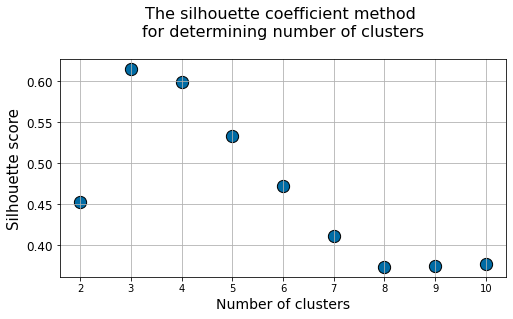

In [17]:
optimal_k_clusters(name_DF = df_scaled, col1 = 'x', col2 = 'z')

### KMeans Algorithm Function

In [18]:
def kmeans_alg(name_DF, col1, col2, no_k):
    global cluster_pred, data_array
    # Drops rows where there are nulls and converts the data to an array which is used as input to kmeans function.
    data_array = name_DF[[col1, col2]].dropna().reset_index(drop=True).to_numpy()    
    
    kmeans = KMeans(n_clusters=no_k, random_state=0).fit(data_array) # Kmeans algorithm.
    cluster_pred = kmeans.labels_ # Predicted cluster label.
    # The code line below modifies cluster "0" to cluster "1" and all other clusters up by 1.  
    # In my experience, non-data scientists find starting Python's 0 index confusing.
    # Note that other clustering algorithms (E.g., DBSCAN) that calculate outliers assign outliers to cluster "-1".
    # I modify outliers to be Cluster "0" which is more intuitive for those records with no cluster assignment.
    cluster_pred = cluster_pred+1
    
    centroids = kmeans.cluster_centers_ # Centroids to mark them in the plot

    # Scatter plot for labeled data.
    plt.figure(figsize=(8,8))
    plt.scatter(data_array[:, 0], data_array[:, 1], 
                marker='o', s=30, lw=0, alpha=1, c=cluster_pred, cmap = 'Set1', edgecolor=None)
    plt.title(label = f"KMeans Cluster Plot. Total Clusters = {no_k}")
    plt.xlabel(col1, fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(col2, fontsize=18)
    plt.yticks(fontsize=14)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker="x", s=240, linewidths=5, color="k", zorder=10)

    Cluster_Plot = plt.show()
    # Note that when using Kmeans in two dimensions the linearly separable characteristic of Kmeans is observed. 

### KMeans: Data Columns X and Z
Let's run the Kmeans algorithm with columns X and Z. From the Silhoutte score we concluded that should have three or four clusters. Let's do 4 clusters. 

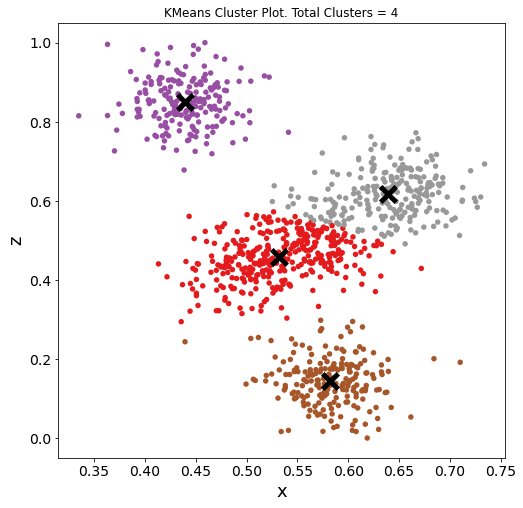

In [21]:
kmeans_alg(name_DF = df_scaled, col1 = 'x', col2 = 'z', no_k = 4)

In [22]:
# We can also get a dataframe of the record assigned cluster label.
df_cluster_label = pd.DataFrame(cluster_pred, columns=['kmeans_cluster_label']) # Creates a table with the cluster label.
df_cluster_label['kmeans_cluster_label'].value_counts()
# Note that by default kmeans cluster use value of 0 as the initial cluster.
# Recall that Python uses a zero-based index  

1    358
4    242
2    200
3    200
Name: kmeans_cluster_label, dtype: int64

In [23]:
print(df_cluster_label['kmeans_cluster_label'].value_counts())
df_cluster_label
# Note that the predicted clusters index should match the ORDER of your input data. 
# If you will combine you need to make sure that the input data index is reset to make sure index match.

1    358
4    242
2    200
3    200
Name: kmeans_cluster_label, dtype: int64


,kmeans_cluster_label
0,1
1,1
2,2
3,4
4,4
...,...
995,3
996,1
997,3
998,1


In [24]:
# Extracting values only for Column z.
df_scaled_col_z = df_scaled[['x', 'z']].dropna().reset_index(drop=True)
# Applying the cluster_label as a column in the scaled dataframe.
df_scaled_col_z['kmeans_cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_scaled_col_z.head(5)
# Once you have this you can filter for specific clusters and analyze data of one cluster together.

,x,z,kmeans_cluster_label
0,0.59,0.47,1
1,0.51,0.41,1
2,0.43,0.83,2
3,0.73,0.61,4
4,0.56,0.56,4


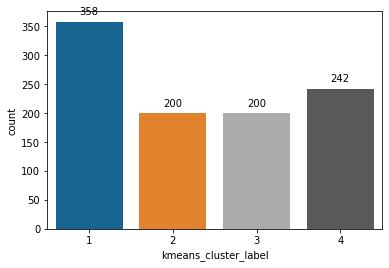

In [25]:
# This plot shows the number of rows that were assigned to each cluster.
cluster_count_figure = sns.countplot(x='kmeans_cluster_label', data = df_scaled_col_z)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()), 
                                  (p.get_x()+p.get_width()/2, p.get_height()), 
                                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

### KMeans: Data Columns X and W
Let's run the Kmeans algorithm with columns X and W . The data in these two columns was only one big cluster. However note that KMeans can also separate clusters like this into however many cluster the user defines.

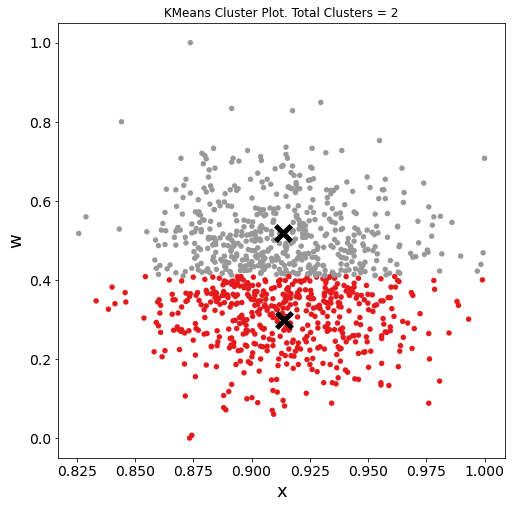

In [26]:
kmeans_alg(name_DF = df_scaled, col1 = 'x', col2 = 'w', no_k = 2)

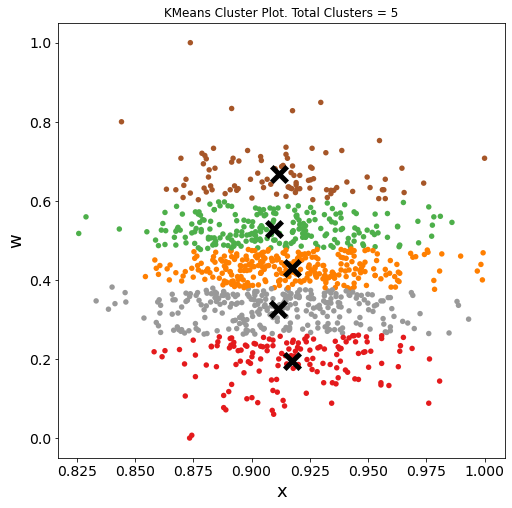

In [27]:
kmeans_alg(name_DF = df_scaled, col1 = 'x', col2 = 'w', no_k = 5)

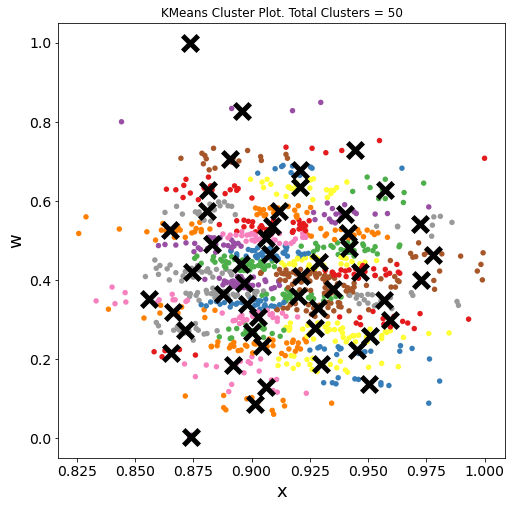

In [30]:
kmeans_alg(name_DF = df_scaled, col1 = 'x', col2 = 'w', no_k = 50)
# We can put many many clusters too.
# But this for sure would be a sub-optimal number of clusters.

In [ ]:
# If you wanted to extract the label assigments you would use the same functions as above.

### KMeans: Other Data Columns
We could do the same thing for the other combinations of X and Y or X and V. Depending on what data we are looking for.


# Clustering: DBSCAN
DBSCAN (Density-based spatial clustering of applications with noise) clustering algorithm is a density based algorithm that groups the data based in a density parameter (i.e., EPS or Epsilon) and a minimum samples in a cluster parameter (i.e., min_samples). The algorithm clusters data by iterating thru the coordinates of each record and checking if adjacent records are within the parameters. If the parameters are met it assigns the cluster. One characteristic of density based clustering algorithms (e.g., DBSCAN) is that they can calculate outliers (i.e., also called noise in the documentation).

In order to ensure that the algorithm selects significant clusters, the user can explore the most optimal values of EPS  parameter. The optimal EPS is calculated using an elbow method were the optimal EPS is were the point of the elbow of maximum inflection. Note that the elbow may be concave or convex depending on the input data. Regardless the case, the optimal is the point of maximum inflection. Note that EPS is sensitive to scale and if not scaled may be difficult to estimate. The minimum samples in a cluster is determined by subject matter expert or user experience with the data. 

References:
- https://scikit-learn.org/stable/modules/clustering.html#dbscan
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- The [Kneed](https://kneed.readthedocs.io/en/stable/) library also can be used to calculate the point of maximum inflection in  elbow method.

### DBSCAN: Optimal EPS

In [31]:
def optimal_eps(name_DF, col1, col2, data_normalized):
    global df_eps_vs_samples 
    
    # Drops rows where there are nulls and converts the data to an array.
    data_array = name_DF[[col1, col2]].dropna().reset_index(drop=True).to_numpy()  

    # This creates the data to determine the optimal density value (EPS). 
    neigh = NearestNeighbors(n_neighbors=2) # Defines the model to calculate nearest neighbors (set to 2).
    nbrs = neigh.fit(data_array) # Fits the data to the model.
    distances, indices = nbrs.kneighbors(data_array) # Calculates the distance
    distances = np.sort(distances, axis=0) # Sorts the distances
    distances = distances[:,1]

    # DataFrame for the "Samples vs. EPS", normalization/scaling and Optimal EPS.
    # Creates a dataframe with the distances to be used in the plot.
    df_eps_vs_samples = pd.DataFrame(distances, columns=['EPS']) 
    df_eps_vs_samples['samples'] = df_eps_vs_samples.index # Creates a column called "samples"
    # Normalizes the samples column.
    df_eps_vs_samples['samples_scaled'] = df_eps_vs_samples['samples']/max(df_eps_vs_samples['samples']) 

    
    # Could calculate the euclidean distance to the bottom right corner.
    # The point with minimum distance could be estimated as the maximum inflection and print that EPS value.
    
    plt.figure(figsize=(8, 8))
    if data_normalized.lower() == 'yes': # If input data is normalized the EPS will be normalized
        # EPS vs Number of Samples, Elbow plot.
        plt.scatter(df_eps_vs_samples['samples_scaled'], 
                    df_eps_vs_samples['EPS'], 
                    marker='.', s=30, lw=0, alpha=1, c=None, edgecolor=None);
    if data_normalized.lower() == 'no': # If input data is NOT normalized will need to scale the EPS.
        # Normalizes the EPS and creates a column with normalized eps.
        # Note that if the data is normalized the EPS will be normalized and no point to use this in the plot. See below
        df_eps_vs_samples['EPS_scaled'] = df_eps_vs_samples['EPS']/max(df_eps_vs_samples['EPS']) 
        # EPS vs Number of Samples, Elbow plot.
        plt.scatter(df_eps_vs_samples['samples_scaled'], 
                    df_eps_vs_samples['EPS_scaled'], 
                    marker='.', s=30, lw=0, alpha=1, c=None, edgecolor=None);
    plt.title(label = f"Scaled Samples vs. Scaled EPS")
    plt.xlabel('samples_scaled', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel('EPS_scaled', fontsize=18)
    plt.yticks(fontsize=14)
    
    plt.show()

### DBSCAN Algorithm Function

In [32]:
def DBSCAN_alg(name_DF, col1, col2, EPS_value, min_samples_inacluster):
    global cluster_pred
    # Drops rows where there are nulls and converts the data to an array which is used as input to kmeans function.
    data_array = name_DF[[col1, col2]].dropna().reset_index(drop=True).to_numpy()  
    
    #min_samples_inacluster = 5 # Minimum number of points for creating a cluster. Use 5 if don't know.

    # Define the model.  EPS is the max distance between points, and defines the density. 
    cluster_pred = DBSCAN(eps= EPS_value, min_samples = min_samples_inacluster).fit_predict(data_array) 
    
    # This modifies cluster "0" as cluster "1" and all other clusters up.
    # This modification clarifies that there is no Cluster 0.  
    cluster_pred = cluster_pred+1
    clusters = unique(cluster_pred) # retrieve unique clusters
    
    # Scatter plot
    plt.figure(figsize=(8,8))
    plt.scatter(data_array[:, 0], data_array[:, 1], 
                marker='o', s=30, lw=0, alpha=1, c=cluster_pred, cmap = 'Set1', edgecolor=None)

    #plt.title(label = f"KMeans Clusters Plot.  Total Clusters = {clusters.max()} with EPS = {EPS_value}")
    plt.xlabel(col1, fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel(col2, fontsize=18)
    plt.yticks(fontsize=14)
    plt.show()

### DBSCAN: : Data Columns X and W

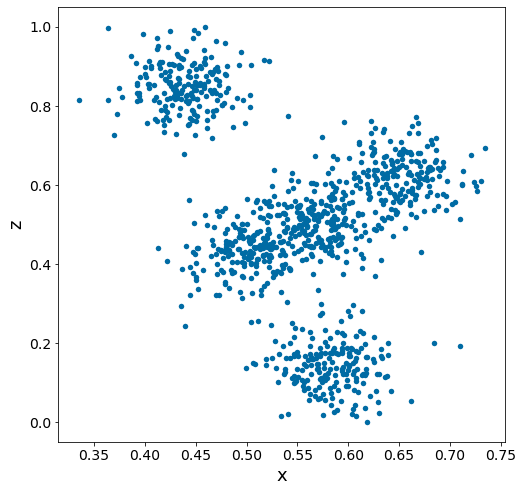

In [33]:
# Recall scatter plot of 'x' and 'z' values.
scatter_plot(col1 = 'x', col2 = 'z')
# Three defined clusters. The middle clusters could potnetially be divided in two.

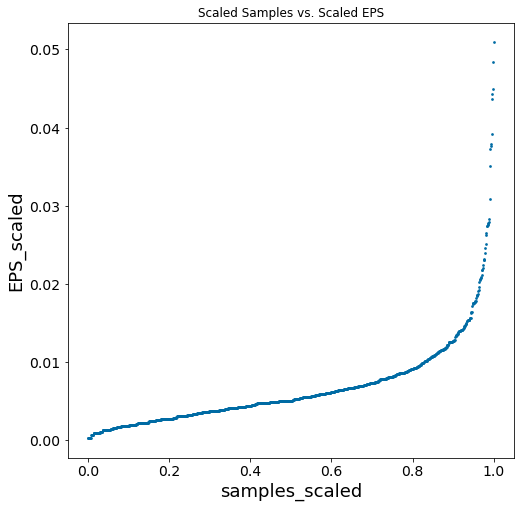

In [34]:
optimal_eps(name_DF = df_scaled, col1 = 'x', col2 = 'z', data_normalized = 'yes')

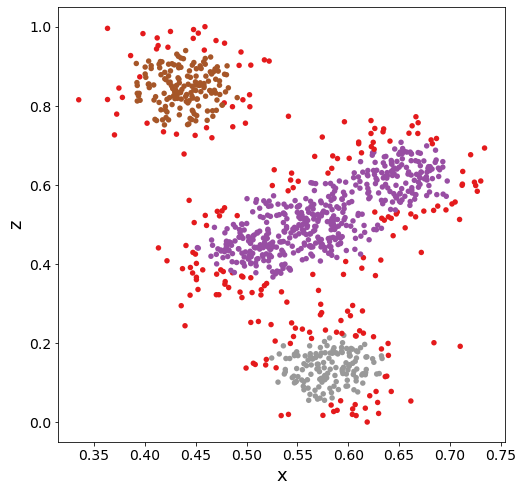

In [40]:
# Optimal EPS_value around 0.015
DBSCAN_alg(name_DF = df_scaled, col1 = 'x', col2 = 'z', EPS_value = 0.02, min_samples_inacluster = 10)
# Depending on how man clusters there are it may be difficult to visualize due to a limited number of colors.

In [41]:
# Creates a new table with the cluster labels.
df_cluster_label = pd.DataFrame(cluster_pred, columns=['dbscan_cluster_label'])
print(df_cluster_label['dbscan_cluster_label'].value_counts().sort_index())
df_cluster_label
# Note Cluster "0" is outliers if any.

0    218
1    484
2    158
3    140
Name: dbscan_cluster_label, dtype: int64


,dbscan_cluster_label
0,1
1,1
2,2
3,0
4,1
...,...
995,3
996,1
997,3
998,1


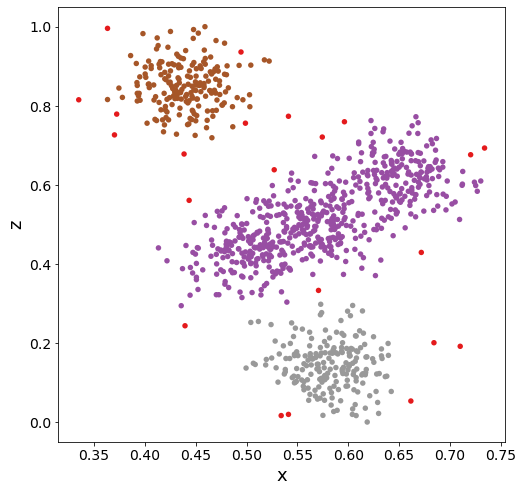

In [42]:
# There are probably too many clusters
DBSCAN_alg(name_DF = df_scaled, col1 = 'x', col2 = 'z', EPS_value = 0.03, min_samples_inacluster = 5)

In [43]:
# Creates a new table with the cluster labels.
df_cluster_label = pd.DataFrame(cluster_pred, columns=['dbscan_cluster_label'])
print(df_cluster_label['dbscan_cluster_label'].value_counts().sort_index())
df_cluster_label
# Note Cluster "0" is outliers if any.

0     22
1    592
2    192
3    194
Name: dbscan_cluster_label, dtype: int64


,dbscan_cluster_label
0,1
1,1
2,2
3,1
4,1
...,...
995,3
996,1
997,3
998,1


In [44]:
# Extracting values only for Column z.
df_scaled_col_z = df_scaled[['x', 'z']].dropna().reset_index(drop=True)
# Applying the cluster_label as a column in the scaled dataframe.
df_scaled_col_z['dbscan_cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_scaled_col_z.head(5)
# Once you have this you can filter for specific clusters and analyze data of one cluster together.

,x,z,dbscan_cluster_label
0,0.59,0.47,1
1,0.51,0.41,1
2,0.43,0.83,2
3,0.73,0.61,1
4,0.56,0.56,1


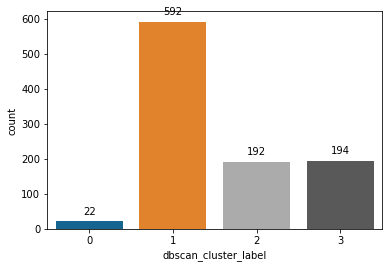

In [45]:
# This plot shows the number of rows that were assigned to each cluster.
cluster_count_figure = sns.countplot(x='dbscan_cluster_label', data = df_scaled_col_z)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()), 
                                  (p.get_x()+p.get_width()/2, p.get_height()), 
                                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#### DBSCAN: Other Data Columns
We could do the same thing for the other combinations of X and other features. Depending on what data we are looking for and which features we are trying to cluster.

# Clustering Conclusions
Same as Kmeans, the DBSCAN also separated the data in groups. Both resulted in different clusters and you need to be aware of the geometry of your data to determine the best clustering algorithm. Other clustering algorithms can be found at https://scikit-learn.org/stable/modules/clustering.html. Implementation may vary but is similar to above.

# NOTEBOOK END